### PCA, k-Means, DBSCAN, select KBest

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Cargar el dataset
iris = load_iris()
X, _ = iris.data, iris.target  # Ignoramos las etiquetas reales

# Separar datos en entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

In [3]:
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['target'] = iris.target

In [4]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [12]:
# Pipeline para generar etiquetas con KMeans y usarlas como target
class KMeansLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 3):
        self.n_clusters = n_clusters

    def fit(self, X, y = None):
        self.kmeans = KMeans(n_clusters = self.n_clusters, random_state = 42)
        self.kmeans.fit(X)
        return self

    def transform(self, X, y = None):
        return self.kmeans.predict(X).reshape(-1, 1)

# Definir transformaciones de preprocesamiento
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', StandardScaler(), slice(0, X.shape[1])),  # Escalar todas las columnas
        ('pca', PCA(), slice(0, X.shape[1]))  # PCA sin número fijo de componentes (será optimizado)
    ],
    remainder = 'passthrough'
)

# Crear el pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clustering', KMeansLabeler(n_clusters = 3)),  # Generar etiquetas con clustering
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [6]:
# Etiquetas generadas por clustering para la optimización
y_generated = KMeans(n_clusters = 3, random_state = 42).fit_predict(X)

# Grid de hiperparámetros a explorar
param_grid = {
    'preprocessing__pca__n_components': [2, 3],  # Número de componentes en PCA
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Configuración de GridSearchCV con 5 particiones para cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X, y_generated)

# Resultados del mejor modelo
print('Best Cross-Validation Score:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Evaluación final con el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print('Classification Report for Best Model:\n', classification_report(y_generated, y_pred))

/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/maria/.pyenv/versions/3.12.4

Best Cross-Validation Score: 0.8466666666666667
Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'preprocessing__pca__n_components': 3}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.68      1.00      0.81        39
           1       1.00      1.00      1.00        50
           2       1.00      0.70      0.83        61

    accuracy                           0.88       150
   macro avg       0.89      0.90      0.88       150
weighted avg       0.92      0.88      0.88       150



In [7]:
iris_df['generated_labels'] = y_generated

In [8]:
c = iris_df[['target', 'generated_labels']]

* target = 0 --> generated = 1
* target = 1 --> generated = 2
* target = 2 --> generated = 0

In [14]:
mapping = {0: 2, 1: 0, 2: 1}
iris_df['aligned_generated'] = iris_df['generated_labels'].map(mapping)

In [15]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,generated_labels,aligned_generated
0,5.1,3.5,1.4,0.2,0,1,0
1,4.9,3.0,1.4,0.2,0,1,0
2,4.7,3.2,1.3,0.2,0,1,0
3,4.6,3.1,1.5,0.2,0,1,0
4,5.0,3.6,1.4,0.2,0,1,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,0,2
146,6.3,2.5,5.0,1.9,2,2,1
147,6.5,3.0,5.2,2.0,2,0,2
148,6.2,3.4,5.4,2.3,2,0,2


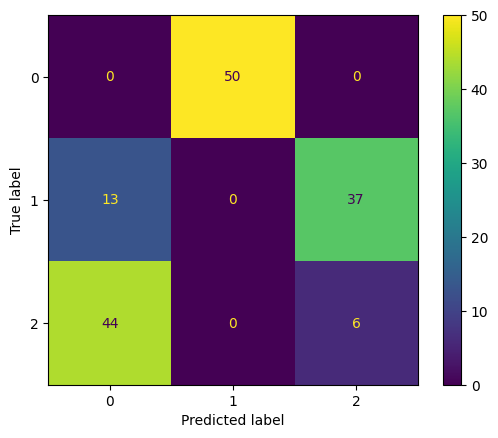

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(iris.target,y_pred);

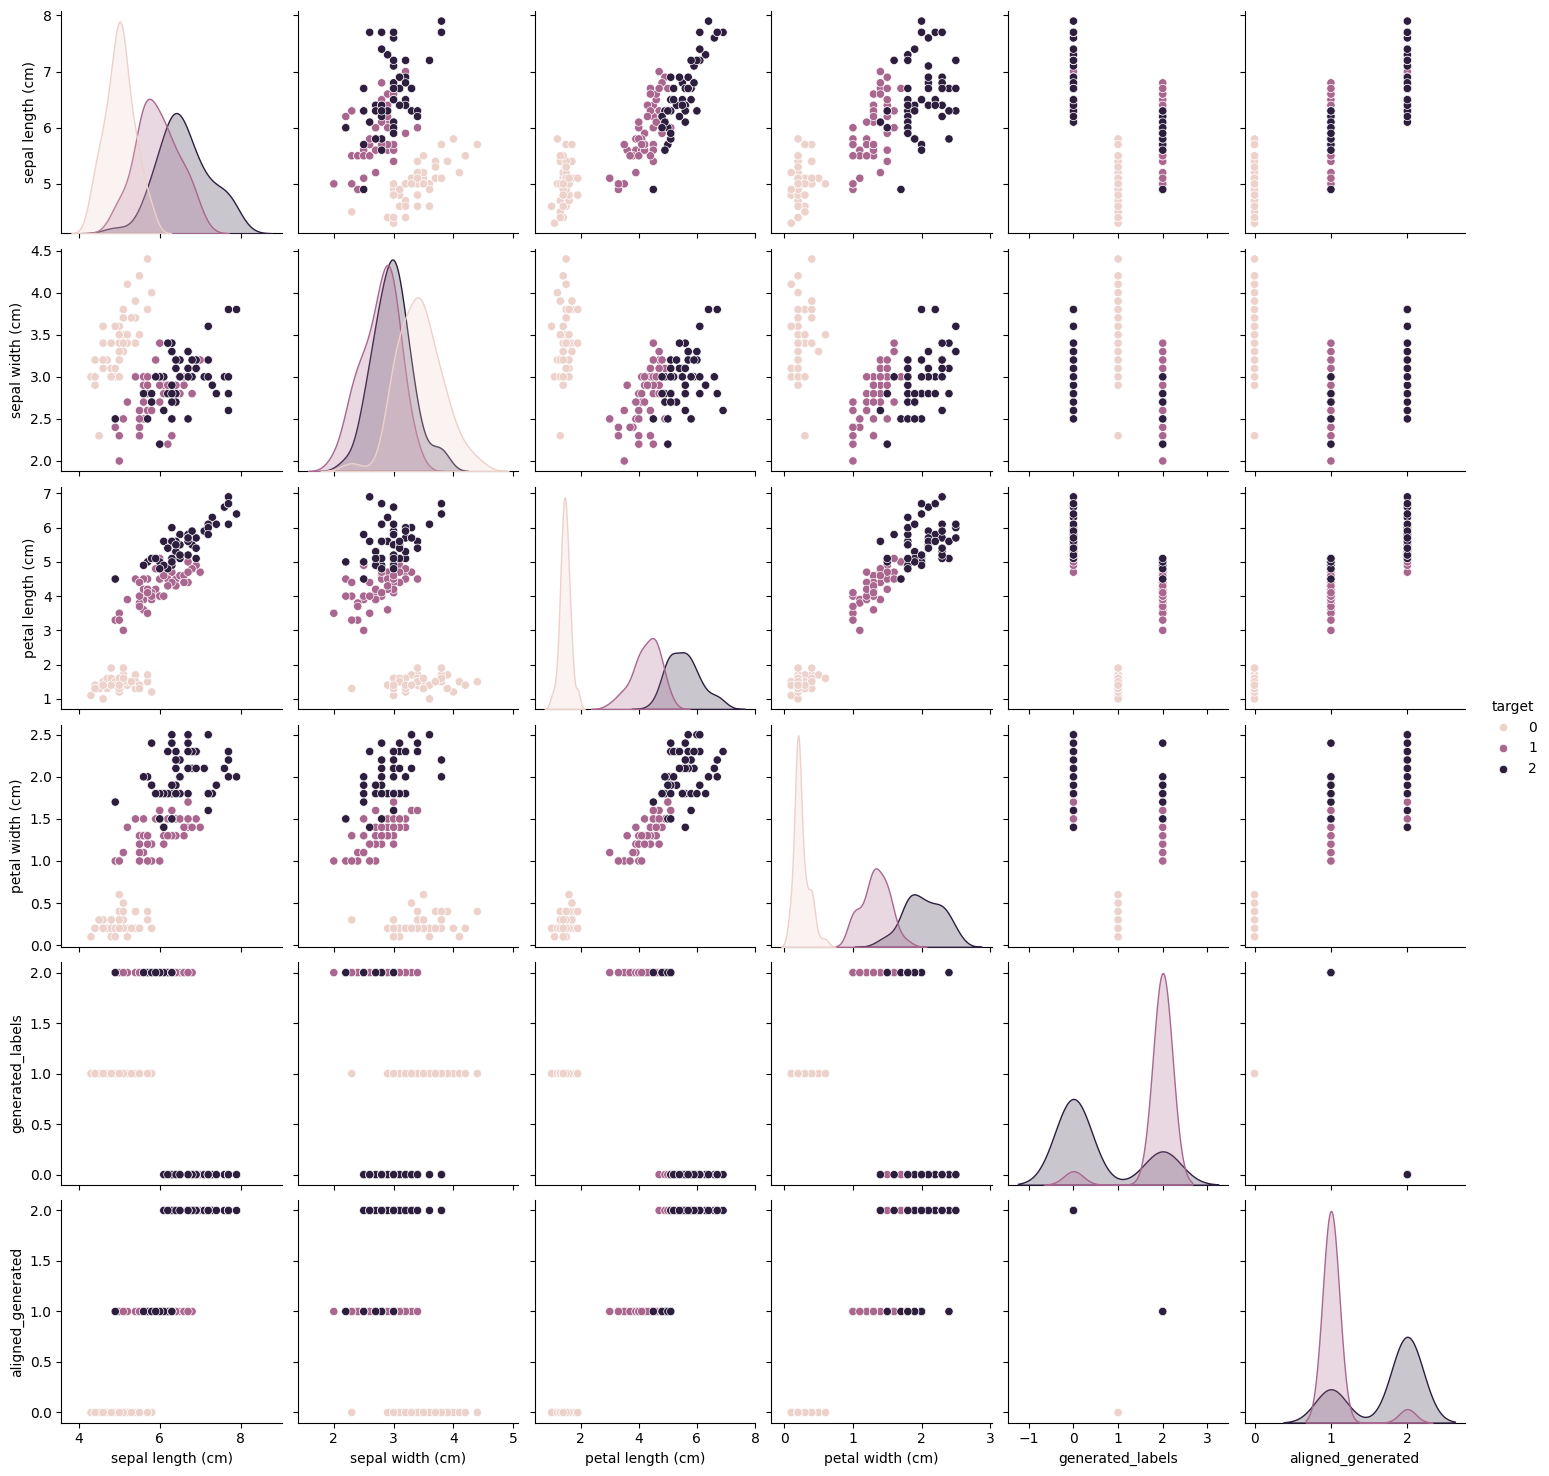

In [17]:
sns.pairplot(iris_df, hue='target');